# <h1 style=' border:1;'><center>Intrusion Detection on UNSBW-NB15 by using Machine Learning Techniques</center></h1>

----
- Date : 12-12-2021
- Group : 22


  Name         | E-Mail   | Code
---------------|--------|------------- 
Eslam Mahmoud| emahm025@uOttawa.ca| 300267020
Loai Nazeer|lnaze101@uOttawa.ca|300266896
Mohamed Elgaidy|  melga045@uOttawa.ca|300267040
Mohamed El-Gharieb|melgh048@uOttawa.ca|300267043



----

#Import Important Pacages

In [1]:
# !pip install -q sklearn_som 
# !pip install -q git+https://github.com/giuliano-oliveira/gdown_folder.git
# !pip install --upgrade numpy
# !pip install -q plotly
# !pip install -q xgboost
# !pip install -q yellowbrick

In [2]:
import pandas as pd
import numpy as np
import random
import gdown
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,normalize,OneHotEncoder
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import StackingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,cross_validate, train_test_split, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report,roc_curve, roc_auc_score , accuracy_score,f1_score
from sklearn.manifold import TSNE
from yellowbrick.classifier import ROCAUC
from sklearn_som.som import SOM
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

# **Load the dataset**

In [3]:
for i in trange(1):
  !gdown --id 1yafPDtNnSxCcYqhE5VhCMTUPk8PGfTXm
  !gdown --id 19EBDKZ1WrFDSqEiIpmgUL3h84jqC2CbQ

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading...
From: https://drive.google.com/uc?id=1yafPDtNnSxCcYqhE5VhCMTUPk8PGfTXm
To: /home/jovyan/git-repos/UNSW_NB15_.csv
100%|██████████████████████████████████████| 15.4M/15.4M [00:00<00:00, 52.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=19EBDKZ1WrFDSqEiIpmgUL3h84jqC2CbQ
To: /home/jovyan/git-repos/train-set_UNSW_NB15_.csv
100%|██████████████████████████████████████| 32.3M/32.3M [00:00<00:00, 63.2MB/s]


100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


In [4]:
train_set = pd.read_csv("./train-set_UNSW_NB15_.csv") #, header = None
test_set = pd.read_csv("./UNSW_NB15_.csv") 

**Features Importance**

In [5]:
# Split the data set
Y_bin = train_set.label
X_bin = train_set.drop(['label', 'attack_cat'], axis=1)

# transfer with label encoding
X_bin = X_bin.apply(LabelEncoder().fit_transform)

X_tr, X_va, y_tr, y_va = train_test_split(X_bin,Y_bin, test_size=0.2, shuffle=True,random_state=42)

In [6]:
model = RandomForestClassifier()
model.fit(X_bin, Y_bin)

varr,fet=[],[]
for i in range(len(X_bin.columns)):
  if model.feature_importances_[i] > 0.02:
    fet.append(model.feature_importances_[i])
    varr.append(X_bin.columns[i])
import_fet=pd.DataFrame({ "Varname": varr, "Imp": fet}) 
import_fet.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,id,0.252455
4,sttl,0.152742
11,ct_state_ttl,0.087428
7,dload,0.051376
3,rate,0.040335
6,sload,0.033653
1,dpkts,0.027353
8,tcprtt,0.026623
10,dmean,0.025811
9,ackdat,0.025221


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


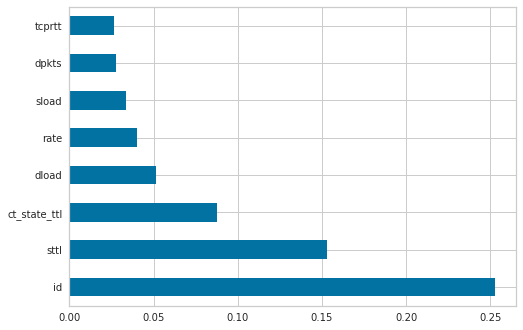

In [7]:
#Features

(pd.Series(model.feature_importances_, index=X_bin.columns)
   .nlargest(8)
   .plot(kind='barh'))

In [8]:
train_set = train_set.drop([ 'stcpb', 'dtcpb', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd','id'], axis=1) # droped label
test_set = test_set.drop([ 'stcpb', 'dtcpb', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd','id'], axis=1) # droped label


# **Data Cleaning & Prepocessing**

In [9]:
'''
Checkng for nulls and drop duplicated values 
'''
(train_set =='-').sum()

test_set.isnull().sum().sum()

print(Counter(train_set.attack_cat))

bin_labels = pd.value_counts(train_set['label'], sort = True)
bin_labels.rename(index={0:'Normal',1:'Attack'})
multi_labels = pd.value_counts(train_set['attack_cat'], sort = True)

train_set.duplicated().sum()

train_set['service'].replace('-',np.nan,inplace=True)
train_set.dropna(inplace=True)

test_set['service'].replace('-',np.nan,inplace=True)
test_set.dropna(inplace=True)

train_set.isnull().sum().sum()

Counter({'Normal': 56000, 'Generic': 40000, 'Exploits': 33393, 'Fuzzers': 18184, 'DoS': 12264, 'Reconnaissance': 10491, 'Analysis': 2000, 'Backdoor': 1746, 'Shellcode': 1133, 'Worms': 130})


0

In [10]:
duplicate = test_set[test_set.duplicated()]
duplicate
print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,response_body_len,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,label
137,1.493380,tcp,http,FIN,10,10,822,1378,12.722817,62,...,190,4,19,3,3,4,3,4,Normal,0
139,1.493380,tcp,http,FIN,10,10,822,1378,12.722817,62,...,190,4,19,3,3,4,3,4,Normal,0
146,1.368353,tcp,http,FIN,10,10,810,1138,13.885306,62,...,199,4,2,2,2,4,3,5,Normal,0
473,1.160125,tcp,ftp,FIN,22,22,1190,1642,37.064971,62,...,0,1,2,1,1,2,2,1,Exploits,1
779,2.032866,tcp,ftp,FIN,22,22,1186,1602,21.152403,62,...,0,1,3,1,1,2,2,1,Exploits,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81159,0.537778,tcp,http,FIN,10,8,824,1188,31.611556,62,...,186,5,2,3,2,4,4,4,Normal,0
81161,0.600837,tcp,http,FIN,10,8,806,1152,28.293864,62,...,169,4,2,2,2,4,2,4,Normal,0
81173,0.793520,tcp,http,FIN,10,8,838,1098,21.423531,62,...,142,2,2,2,2,3,2,2,Normal,0
81179,0.513647,tcp,http,FIN,10,8,822,1276,33.096658,62,...,231,5,2,2,2,5,2,5,Normal,0


**Data Insights**

/n


Text(0, 0.5, 'Frequency')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


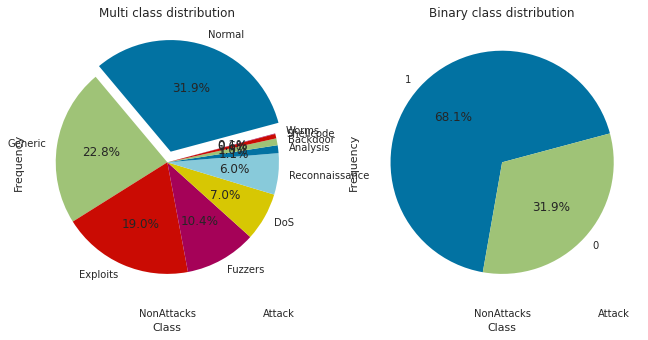

In [11]:
# Mutli Plot

labels = ['NonAttacks','Attack']
my_explode = [0.1,0,0,0,0,0,0,0,0,0]
plt.subplot(1, 2, 1)
multi_labels.plot(kind = 'pie', rot=0,figsize=(11, 6), explode=my_explode, autopct='%1.1f%%', startangle=15,)
plt.title("Multi class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
print('/n')

# Binary Plot
plt.subplot(1, 2, 2)
bin_labels.plot(kind = 'pie', rot=0,figsize=(11, 6),autopct='%1.1f%%', startangle=15,)
plt.title("Binary class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")


<AxesSubplot:>

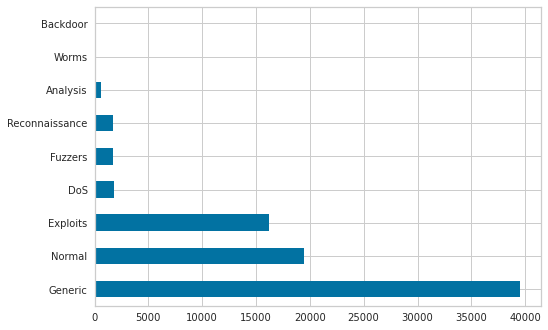

In [12]:
train_set.attack_cat.value_counts().plot.barh()

In [13]:
train_set.attack_cat.value_counts()

Generic           39496
Normal            19488
Exploits          16187
DoS                1791
Fuzzers            1731
Reconnaissance     1703
Analysis            564
Worms               114
Backdoor             99
Name: attack_cat, dtype: int64

<AxesSubplot:>

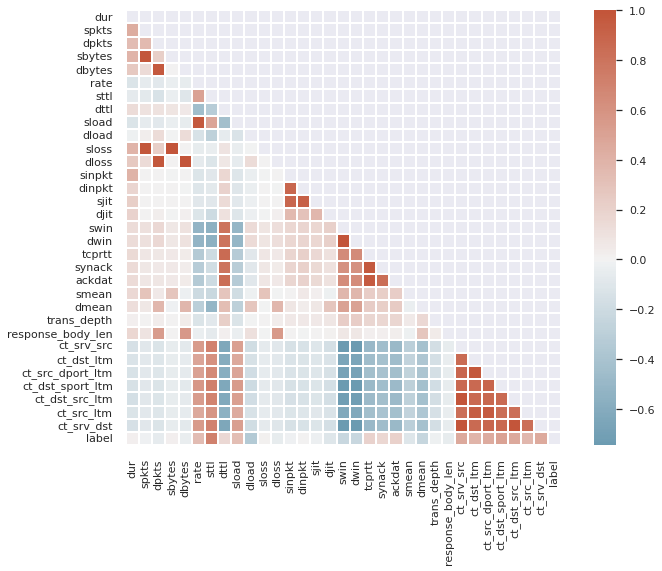

In [14]:
import seaborn as sns
corr = train_set.corr()

sns.set_theme('notebook')

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=1.)


In [15]:
pd.set_option('display.max_columns', None)

isna = pd.DataFrame(train_set.isna().sum().values.reshape(1, 37), columns=train_set.columns, index=['NA'])
isnull = pd.DataFrame(train_set.isnull().sum().values.reshape(1, 37), columns=train_set.columns, index=['Null'])

print(pd.concat([isna, isnull]).sum().sum())
pd.concat([isna, isnull])

0


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,label
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# Split the data set
Y_bin = train_set.label
X_bin = train_set.drop(['label', 'attack_cat'], axis=1)

# transfer with label encoding
X_bin = X_bin.apply(LabelEncoder().fit_transform)

X_tr, X_va, y_tr, y_va = train_test_split(X_bin,Y_bin, test_size=0.2, shuffle=True,random_state=42)

# **Binary Model**

In [17]:
# Function for plot ROC curve
le = LabelEncoder()
encode_label = le.fit_transform(Y_bin.unique())
dict_code = dict(zip(Y_bin.unique(),encode_label))

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
    try:                                    
      # Fitting to the training data first then scoring with the test data                                    
      visualizer.fit(xtrain, ytrain)
      visualizer.score(xtest, ytest)
      g= visualizer.show()
    except AttributeError:
      pass
    return 

**Random Forest**

In [18]:
rf_bin = RandomForestClassifier(criterion="gini",max_depth=20,min_samples_leaf=4,min_samples_split=5,random_state=42, n_jobs=-1)
rf_bin.fit(X_tr,y_tr).score(X_va,y_va)

0.9868801971050201

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.99     16235
   macro avg       0.99      0.98      0.98     16235
weighted avg       0.99      0.99      0.99     16235



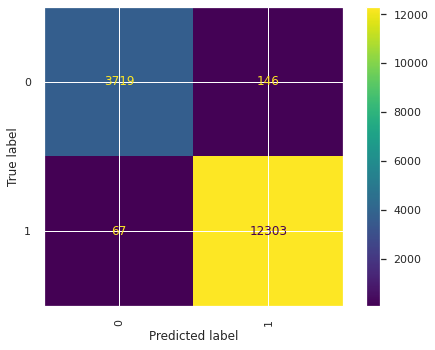

In [19]:
#Results
print(classification_report(y_va,rf_bin.predict(X_va)))

#plot confusion matrix
plot_confusion_matrix(rf_bin, X_va, y_va,xticks_rotation="vertical")
plt.show()

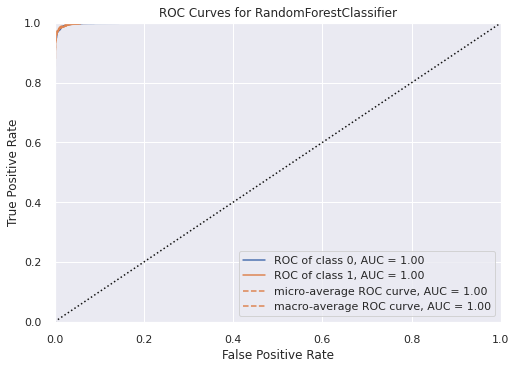

In [20]:
plot_ROC_curve(rf_bin, X_tr, y_tr , X_va ,y_va)

**XGB Classifier**

In [21]:
model_xgb_bin = XGBClassifier(n_jobs=-1)
model_xgb_bin.fit(X_tr,y_tr).score(X_va,y_va)

[03:57:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9872497690175547

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.99     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.99      0.99      0.99     16235



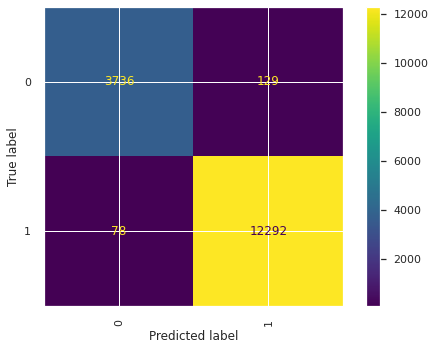

In [22]:
print(classification_report(y_va,model_xgb_bin.predict(X_va)))
plot_confusion_matrix(model_xgb_bin, X_va, y_va,xticks_rotation="vertical")  
plt.show()

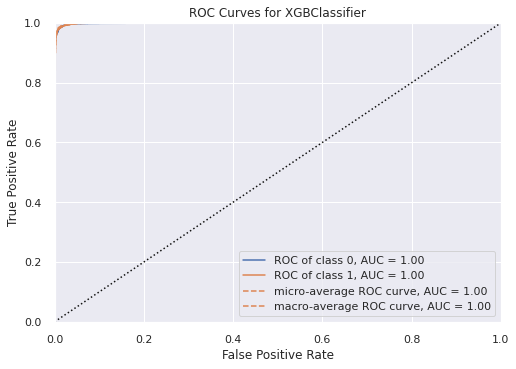

In [23]:
plot_ROC_curve(model_xgb_bin, X_tr, y_tr , X_va ,y_va)

**Decision Tree Classifier**

In [24]:
dt_bin = DecisionTreeClassifier(max_depth=12,min_samples_leaf=3,min_samples_split=7,random_state=42)
dt_bin.fit(X_tr,y_tr).score(X_va,y_va)

0.983615645210964

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.98     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.98      0.98      0.98     16235



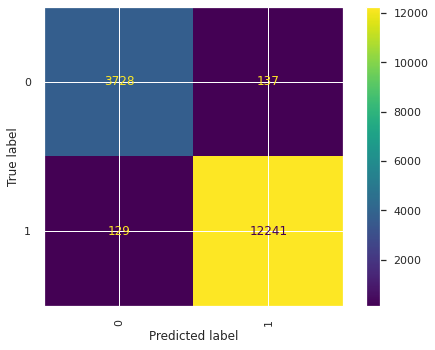

In [25]:
print(classification_report(y_va,dt_bin.predict(X_va)))
plot_confusion_matrix(dt_bin, X_va, y_va,xticks_rotation="vertical")  
plt.show()

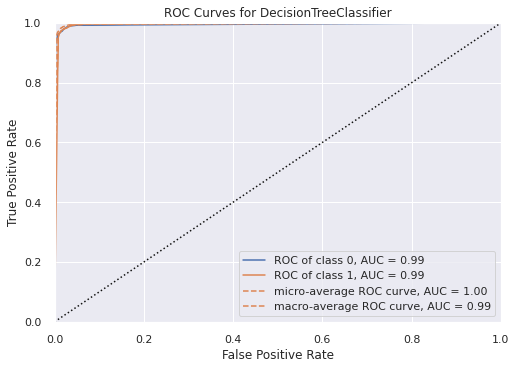

In [26]:
plot_ROC_curve(dt_bin, X_tr, y_tr , X_va ,y_va)

**Stacking**

In [27]:
models = [
    ("xgb",XGBClassifier()),
    ("dt", make_pipeline(DecisionTreeClassifier(max_depth=15))),
    ('rf', RandomForestClassifier())
    ]

stacking_bin = StackingClassifier(estimators=models,final_estimator=RandomForestClassifier(),cv=5)
stacking_bin.fit(X_tr,y_tr).score(X_va,y_va)

[03:57:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:57:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.9859562673236834

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3865
           1       0.99      0.99      0.99     12370

    accuracy                           0.99     16235
   macro avg       0.98      0.98      0.98     16235
weighted avg       0.99      0.99      0.99     16235



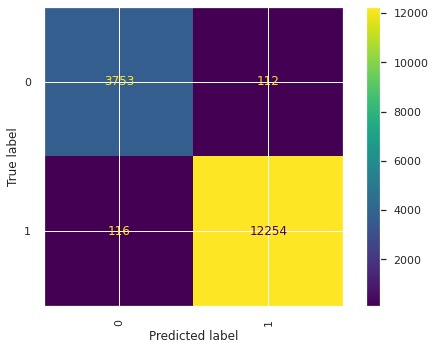

In [28]:
print(classification_report(y_va,stacking_bin.predict(X_va)))
plot_confusion_matrix(stacking_bin, X_va, y_va,xticks_rotation="vertical")  
plt.show()

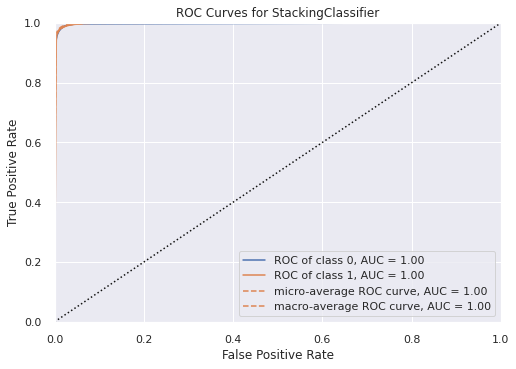

In [29]:
plot_ROC_curve(stacking_bin, X_tr, y_tr , X_va ,y_va)

**Make a Prediction on test dtaset**

In [30]:
Y_test = test_set.label

X_test = test_set.drop(['label', 'attack_cat'], axis=1) #, 'attack_cat'

# transfer with label encoding
X_test = X_test.apply(LabelEncoder().fit_transform)

ypred = model_xgb_bin.predict(X_test)
f1score = f1_score(Y_test, ypred)# , average='weighted'
print ("Accuracy for binary Test set = ",accuracy_score(Y_test, ypred ))
print ("F1 Score for binary Test set = ",f1score)

print(classification_report(Y_test, ypred))

Accuracy for binary Test set =  0.9254100457659399
F1 Score for binary Test set =  0.9510849302811126
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      9625
           1       0.91      1.00      0.95     25554

    accuracy                           0.93     35179
   macro avg       0.95      0.87      0.90     35179
weighted avg       0.93      0.93      0.92     35179



# **Multiclass Model**

In [35]:
num_col = train_set.select_dtypes(include='number').columns
len(num_col)

cat_col = train_set.columns.difference(num_col)
cat_col = cat_col.drop(['attack_cat'])

print(num_col.shape)
train_cat = train_set[cat_col].copy()

train_cat = pd.get_dummies(train_cat,columns=cat_col)
print(train_cat.shape)


train_num = train_set[num_col].copy()




data = pd.concat([train_set, train_cat],axis=1)
print(data.shape)

data.drop(columns=cat_col,inplace=True)
print(data.shape)


# data.info()
# num_col
# data.shape

data = data.drop(['state_RST'], axis=1) 

print(data.shape)

(33,)
(81173, 19)
(81173, 56)
(81173, 53)
(81173, 52)


In [36]:
#drop Normal Cat from train set
remove = data[data['attack_cat']=='Normal'].index
data_te = data.drop(remove)

In [37]:
Y = data_te.attack_cat
X = data_te.drop(['label', 'attack_cat'], axis=1) #, 'attack_cat'

# transfer with label encoding
# X = X.apply(LabelEncoder().fit_transform)

# scale features
scaler = MinMaxScaler()
model=scaler.fit(X)
X=model.transform(X)

X.shape

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, shuffle=True)

**Random Forest**

In [38]:
rf = RandomForestClassifier(criterion="entropy",max_depth=12,min_samples_leaf=2,min_samples_split=4
                            ,random_state=42, n_jobs=-1)
rf.fit(X_train,y_train).score(X_val,y_val)

0.9410715733160412

                precision    recall  f1-score   support

      Analysis       0.77      0.80      0.78       119
      Backdoor       0.75      0.25      0.38        24
           DoS       0.75      0.20      0.31       332
      Exploits       0.85      0.96      0.90      3264
       Fuzzers       0.95      0.91      0.93       345
       Generic       1.00      0.99      1.00      7878
Reconnaissance       0.63      0.53      0.57       353
         Worms       0.50      0.05      0.08        22

      accuracy                           0.94     12337
     macro avg       0.77      0.59      0.62     12337
  weighted avg       0.94      0.94      0.93     12337



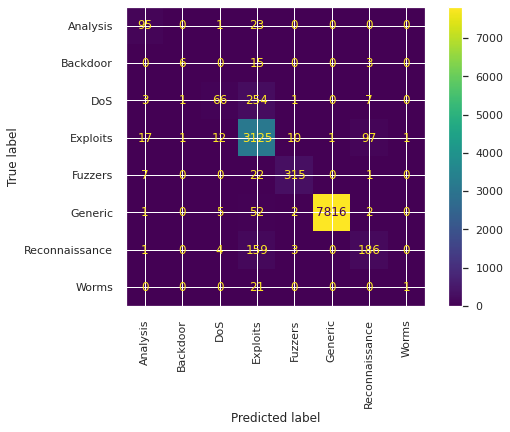

In [39]:
#Results
print(classification_report(y_val,rf.predict(X_val)))

#plot confusion matrix
plot_confusion_matrix(rf, X_val, y_val,xticks_rotation="vertical")
plt.show()

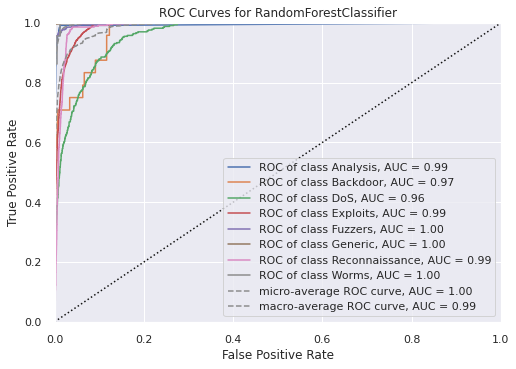

In [40]:
plot_ROC_curve(rf, X_train, y_train,X_val,y_val)

**XGB Classifier**

In [41]:
model_xgb = XGBClassifier(n_estimators=50,max_depth=20 ,n_jobs=-1,random_state=42)
model_xgb.fit(X_train, y_train).score(X_val, y_val)

[04:03:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9452054794520548

                precision    recall  f1-score   support

      Analysis       0.77      0.88      0.82       119
      Backdoor       0.86      0.50      0.63        24
           DoS       0.69      0.39      0.50       332
      Exploits       0.88      0.93      0.91      3264
       Fuzzers       0.96      0.92      0.94       345
       Generic       1.00      1.00      1.00      7878
Reconnaissance       0.59      0.56      0.58       353
         Worms       0.50      0.55      0.52        22

      accuracy                           0.95     12337
     macro avg       0.78      0.72      0.74     12337
  weighted avg       0.94      0.95      0.94     12337



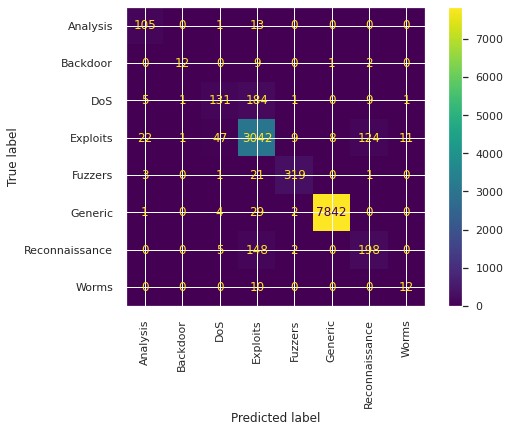

In [42]:
print(classification_report(y_val,model_xgb.predict(X_val)))
plot_confusion_matrix(model_xgb, X_val, y_val,xticks_rotation="vertical")  
plt.show()

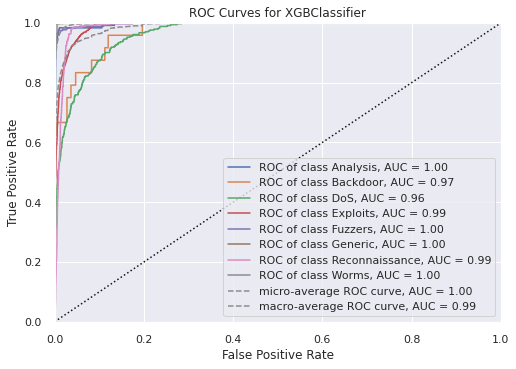

In [43]:
plot_ROC_curve(model_xgb, X_train, y_train,X_val,y_val)

**Decision Tree Classifier**

In [44]:
dt = DecisionTreeClassifier(max_depth=12,min_samples_leaf=7,
                             min_samples_split=2,random_state=42)
dt.fit(X_train, y_train).score(X_val, y_val)

0.9358028694172003

                precision    recall  f1-score   support

      Analysis       0.70      0.79      0.74       119
      Backdoor       0.67      0.17      0.27        24
           DoS       0.48      0.35      0.40       332
      Exploits       0.87      0.91      0.89      3264
       Fuzzers       0.92      0.90      0.91       345
       Generic       1.00      0.99      1.00      7878
Reconnaissance       0.59      0.57      0.58       353
         Worms       0.53      0.45      0.49        22

      accuracy                           0.94     12337
     macro avg       0.72      0.64      0.66     12337
  weighted avg       0.93      0.94      0.93     12337



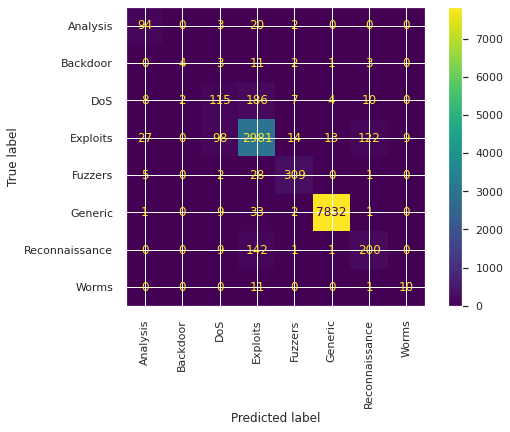

In [45]:
print(classification_report(y_val,dt.predict(X_val)))
plot_confusion_matrix(dt, X_val, y_val,xticks_rotation="vertical")  
plt.show()

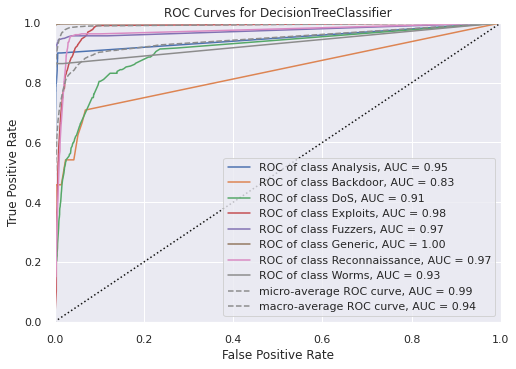

In [46]:
plot_ROC_curve(dt, X_train, y_train,X_val,y_val)

**Stacking**

In [47]:
models = [
    ("xgb",XGBClassifier()),
    ("dt", make_pipeline(DecisionTreeClassifier(max_depth=15))),
    ('rf', RandomForestClassifier())
    ]

stacking = StackingClassifier(estimators=models,final_estimator=RandomForestClassifier(),cv=5)
stacking.fit(X_train, y_train).score( X_val, y_val)

[04:03:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:04:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:05:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:05:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

0.9457728783334685

                precision    recall  f1-score   support

      Analysis       0.74      0.86      0.79       119
      Backdoor       0.86      0.50      0.63        24
           DoS       0.71      0.42      0.53       332
      Exploits       0.88      0.93      0.91      3264
       Fuzzers       0.97      0.94      0.95       345
       Generic       1.00      1.00      1.00      7878
Reconnaissance       0.60      0.52      0.56       353
         Worms       0.54      0.59      0.57        22

      accuracy                           0.95     12337
     macro avg       0.79      0.72      0.74     12337
  weighted avg       0.94      0.95      0.94     12337



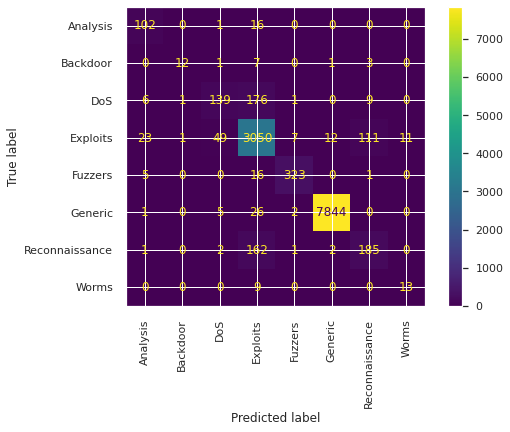

In [48]:
print(classification_report(y_val,stacking.predict(X_val)))
plot_confusion_matrix(stacking, X_val, y_val,xticks_rotation="vertical")  
plt.show()

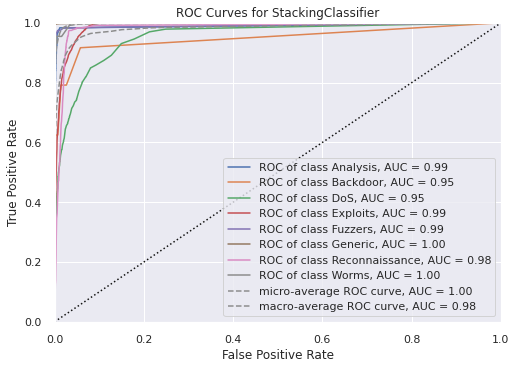

In [49]:
plot_ROC_curve(stacking, X_train, y_train,X_val,y_val)

**Prediction of Test Data Set**

In [51]:
num_col = test_set.select_dtypes(include='number').columns
len(num_col)

cat_col = test_set.columns.difference(num_col)

cat_col = cat_col.drop('attack_cat')
print(num_col.shape)
train_cat = test_set[cat_col].copy()

train_cat = pd.get_dummies(train_cat,columns=cat_col)
print(train_cat.shape)

data_test = pd.concat([test_set, train_cat],axis=1)
print(data_test.shape)

data_test.drop(columns=cat_col,inplace=True)
data_test = data_test.drop(['state_ACC'], axis=1)

remove_nor = data_test[data_test['attack_cat']=='Normal'].index
data_test = data_test.drop(remove_nor)
# data_test.info()

Y_test = data_test.attack_cat

X_test = data_test.drop(['label', 'attack_cat'], axis=1) #, 'attack_cat'
num_col

# scale features
scaler = MinMaxScaler()
model=scaler.fit(X_test)
X_test=model.transform(X_test)

print(X.shape)

#data_test = data_test.drop(['state_ACC'], axis=1) 
print(data_test.shape)

(33,)
(35179, 19)
(35179, 56)
(61685, 50)
(25554, 52)


In [52]:
remove_nor = data_test[data_test['attack_cat']=='Normal'].index
data_test = data_test.drop(remove_nor)
Y_test.value_counts()

Generic           18460
Exploits           5293
DoS                 717
Fuzzers             535
Reconnaissance      504
Worms                34
Backdoor             11
Name: attack_cat, dtype: int64

In [53]:
predc = model_xgb.predict(X_test)
f1score = f1_score(Y_test, predc,average='weighted')
print ("Accuracy for binary Test set = ",accuracy_score(Y_test, predc ))
print ("F1 Score for binary Test set = ",f1score)

print(classification_report(Y_test, predc))

Accuracy for binary Test set =  0.9465054394615324
F1 Score for binary Test set =  0.9434890181924955
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00         0
      Backdoor       0.18      0.18      0.18        11
           DoS       0.69      0.28      0.40       717
      Exploits       0.85      0.93      0.89      5293
       Fuzzers       0.95      0.85      0.90       535
       Generic       1.00      0.99      0.99     18460
Reconnaissance       0.51      0.63      0.56       504
         Worms       0.55      0.18      0.27        34

      accuracy                           0.95     25554
     macro avg       0.59      0.51      0.52     25554
  weighted avg       0.95      0.95      0.94     25554

